In [1]:
# Import necessary modules 
from joblib import dump, load
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split

G:\Anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
%%time 

# Load csv data as a dataframe 
df = pd.read_csv('Intermediate_data\Trimmed.csv', 
                 parse_dates = ['earliest_cr_line', 'issue_d', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d'])

df['history'] = (df.issue_d - df.earliest_cr_line).dt.days 

df.drop([], axis = 1, inplace =  True)

# Drop unnecessary columns and the columns that are leaks the information. For example, non-zero value in
# 'collection recovery fee' column already mean that the loan is default. Also remove some columns that have 
# very little or zero predictive power

df.drop(['last_pymnt_amnt', 'collection_recovery_fee', 'recoveries', 'out_prncp_inv', 
         'out_prncp', 'total_rec_prncp', 'Unnamed: 0', 'total_pymnt', 'total_pymnt_inv',
         'total_rec_late_fee', 'total_rec_int', 'emp_title', 'debt_settlement_flag', 
         'addr_state', 'purpose', 'delinq_amnt', 'hardship_flag', 'pymnt_plan', 
         'collections_12_mths_ex_med', 'chargeoff_within_12_mths', 'acc_now_delinq', 
         'earliest_cr_line', 'issue_d', 'last_pymnt_d', 'next_pymnt_d', 
         'last_credit_pull_d'],
         axis = 1, inplace = True)

print('done')

done
Wall time: 4min 33s


In [3]:
# Some columns are categorical. I converted them to categorical dummies (0 or 1)
cate_list = list(df.dtypes[df.dtypes == 'object'].index)
df_cate = df[cate_list]

df_cat_dum = pd.get_dummies(df_cate, drop_first = True)
y1 = 1 - df_cat_dum['loan_status_Late/Charged Off']
df_cat_dum.drop('loan_status_Late/Charged Off', axis = 1, inplace = True)

# Create the subset of numerical columns. 
df_num_col = df.dtypes[df.dtypes == 'float64']
df_num = df[list(df_num_col.index)]

# Some of the numerical columns contains missing values. I filled the missing values using 
# the mean value of the column. 
for col in df_num.columns:
    df_num[col].fillna(df_num[col].mean(), inplace = True)

# Combine categorical and numerical columns
df_com = pd.concat([df_num, df_cat_dum], axis = 1)

# Combine both subsample of default or non-default loans
y = df_com['int_rate']
X = df_com.drop(['int_rate'], axis = 1).values

# Scale the data to their standard values. 
X = StandardScaler().fit_transform(X)

G:\Anaconda\lib\site-packages\pandas\core\generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [4]:
# Load the model 
model = load('Grad_boosting.joblib')

# Make prediction
prob = model.predict_proba(X)

# Calculate the risk of the loans
risk_new = pd.Series(prob[:,0])

# Estimate the risk of Loan from the interest column of Lending club
risk = ((y -y.min())/(y.max() - y.min()))


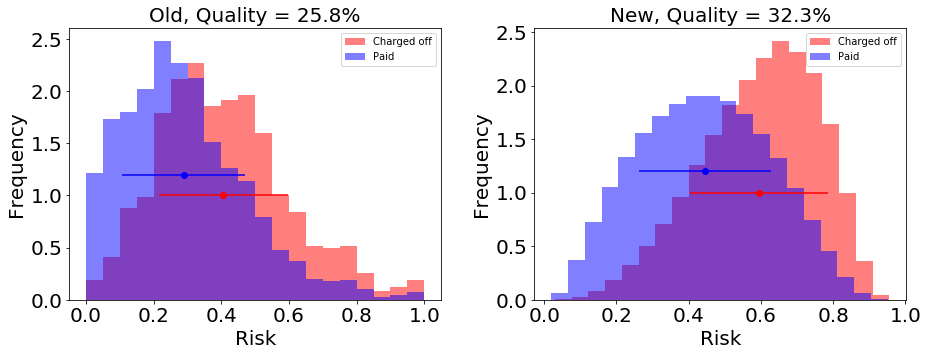

In [5]:
fig, ax = plt.subplots(ncols = 2, nrows = 1, figsize = (15, 5))

# Plot histogram of risk estimated from interest column 
hist1= ax[0].hist(risk[y1 == 0], bins = 20, density = True, 
           color = 'red', label = 'Charged off', alpha = 0.5)
hist2 = ax[0].hist(risk[y1 == 1], bins = 20, density = True, 
           color = 'blue', label = 'Paid', alpha = 0.5)
ax[0].errorbar(risk[y1 == 0].mean(), 1.0, xerr= risk[y1 == 0].std(),
                 color = 'r', marker = 'o')
ax[0].errorbar(risk[y1 == 1].mean(), 1.2, xerr= risk[y1 == 1].std(), 
                 color = 'b', marker = 'o')

# Measure quality of previous model
quality = []
q = (1 - np.minimum(hist1[0], hist2[0]).sum()/hist2[0].sum())*100
q = round(q, 1)
quality.append(q)

# Plot histogram of risk calculated from our data
hist1_new = ax[1].hist(risk_new[y1 == 0], bins = 20, density = True, 
           color = 'red', label = 'Charged off', alpha = 0.5)
hist2_new = ax[1].hist(risk_new[y1 == 1], bins = 20, density = True, 
           color = 'blue', label = 'Paid', alpha = 0.5)
ax[1].errorbar(risk_new[y1 == 0].mean(), 1.0, xerr= risk[y1 == 0].std(),
                 color = 'r', marker = 'o')
ax[1].errorbar(risk_new[y1 == 1].mean(), 1.2, xerr= risk[y1 == 1].std(), 
                 color = 'b', marker = 'o')

q = (1 - np.minimum(hist1_new[0], hist2_new[0]).sum()/hist2_new[0].sum())*100
quality.append(round(q, 1))

quality = iter(quality) 

axes_title = iter(['Old', 'New'])

for ax in ax:
    ax.tick_params(axis = 'both', labelsize=20)
    ax.set_xlabel('Risk', fontsize = 20)
    ax.set_ylabel('Frequency', fontsize = 20)
    ax.set_title(str(next(axes_title)) + ', Quality = ' + str(next(quality)) + '%', 
                 fontsize = 20)
    ax.legend()

plt.subplots_adjust(wspace = 0.25)
